In [1]:
import random
import matplotlib.pyplot as plt
from SUMOSimulation import SUMO

# Ubicación de los archivos de simulación de la red vial:
infoSUMO = {
    'projectFolder': r"SUMO_Simulation\RedVialZMG",
    'netFile': "\osm.net.xml", # Nombre del archivo que contiene la red
    'sumoCfgFile': "\osm.sumocfg" # Nombre del archivo principal de ejecución de SUMO
    }

#Dicionario de clusters de intersecciones: {id_custer: [genotipo del tiempo en verde de cada semáforo], [archivos de detectores de vehículos]}
ampelDict = {"cluster_1395059763_1658290098": [[], ["\Torres.xml", "\Belizario.xml", "\Torres2Belizario.xml"]]} 

# Parámetros de inicio del algoritmo genético:
SIMULATION_TIME = 300 # Tiempo de ejecución de la simulación en segundos
POPULATION_SIZE = 100
GENERATIONS = 50
CROSSOVER_ODDS = .8
MUTATION_ODDS = .2
MIN_TIME = 20 # Tiempo mínimo en verde
MAX_TIME = 120 # Tiempo máximo en verde
RESOLUTION = 8 # bits: resolución del valor de tiempo del semáforo

#Número de semáforos:
nAmpels = len(ampelDict["cluster_1395059763_1658290098"][1]) # Cada archivo corresponde a un semáforo o cruce

#Número máximo posible que puede tomar el gen en base a la resolución  de bits:
maxGenVal = 2**RESOLUTION # 2^n


def generatePopulation():
    """Se genera la población inicial de manera aleatoria"""
    return [''.join(f"{random.randint(0, maxGenVal):0{RESOLUTION}b}" for _ in range(nAmpels)) for _ in range(POPULATION_SIZE)]

def calculateFitness(chromosome, vehicleRates):
    """Se calcula el tiempo total y penaliza los semáforos con flujo bajo y tiempos en VERDE altos"""
    ampelTimes = gen2fen(chromosome)
    totalFlow = 0 # Suma de tasas de flujos
    penalization = 0 # Penalización de tiempo para el cromosoma

    for i in range(len(ampelTimes)-1):
        time = ampelTimes[i] # Tiempo del alelo actual (semáforo)
        cVehicleRate = vehicleRates[i] # Tasa de vehiculos correspondiente al alelo actual (semáforo)
        flow = time * cVehicleRate # Factor de flujo = tiempo en verde * la tasa de vehiculos del semáforo actual
        totalFlow += flow

        # Se penalizan largos tiempos en verde para tasas bajas de vehículos:
        if cVehicleRate < 0.3:
            penalization += (time - MIN_TIME)

    # Fitness bruto: flujo total menos penalización
    rawFitness = totalFlow - penalization

    # Normalización entre 0 - 1:
    maxPossibleFlow = MAX_TIME * sum(vehicleRates)  # Flujo máximo posible
    normalizedFitness = max(0, rawFitness) / maxPossibleFlow  # Normalizar y evitar valores negativos
    
    return normalizedFitness

def selection(population, fitness):
    """Se selecciona de manera elitista el mejor individuo de la generación"""
    fittedPopulation = list(zip(population, fitness)) # Se crean pares (población, fitness)
    bestFit = max(fittedPopulation, key=lambda x: x[1]) # Se selecciona el individuo con mejor fitness
    bestChromosome = bestFit[0] #Se guarda el mejor individuo

    return bestChromosome

def crossover(parent1, parent2):
    """Se ejecuta la cruza con el método de 'Cruza de un Punto' entre los padres"""
    if random.random() < CROSSOVER_ODDS:
        crossoverPoint = random.randint(1, len(parent1)-1) #Se selecciona el punto de cruza a partir del tamaño estándar del individuo
        child1 = parent1[:crossoverPoint] + parent2[crossoverPoint:] # De la cruza se genera el hijo 1
        child2 = parent2[:crossoverPoint] + parent1[crossoverPoint:] # De la cruza se genera el hijo 2

    else:
        child1 = parent1
        child2 = parent2

    return child1, child2

def mutation(chromosome):
    """Se ejecuta la mutación mediante 'Bit Fip' de un alelo"""
    if random.random() < MUTATION_ODDS:
        pos = random.randint(0, len(chromosome)-1) # Posición del alelo a mutar (aleatoria)
        mutatedChromosome = chromosome[:pos] + ('1' if chromosome[pos] == '0' else '0') + chromosome[pos+1:] # 1 -> 0 | 0 -> 1
        return mutatedChromosome
    else:
        return chromosome

def gen2fen(chromosome):
    """Transforma una representación de genotipo a su fenotipo correspondiente"""
    def mapGenotype(gen):
        """ Realiza el mapeo del valor binario al decimal entre los rangos MIN_TIME y MAX_TIME"""
        gen_i = int(gen,2) # Valor del gen en decimal
        return MIN_TIME + ((gen_i/maxGenVal) * (MAX_TIME-MIN_TIME))

    allGens = [chromosome[i:i+RESOLUTION] for i in range(0, len(chromosome), RESOLUTION)]
    ampelTimes = [mapGenotype(gen) for gen in allGens]

    return ampelTimes


In [2]:
import matplotlib.pyplot as plt

def ampelOptimizationGA(showSimulation=False):
    """Obtiene los mejores tiempos en un sistema de semáforos para optimizar los tiempos de espera en intersecciones"""
    population = generatePopulation()
    vehicleRates = [random.random() for _ in range(nAmpels)]
    
    # Listas para recolectar datos de cada generación
    bestFitnessPerGen = []
    avgFitnessPerGen = []
    vehicleRatesPerGen = []

    for generation in range(GENERATIONS):
        next_generation = []
        # Obtener la aptitud de cada individuo:
        cFitness = [calculateFitness(chromosome, vehicleRates) for chromosome in population]

        # Almacenar datos de fitness
        bestFitness = max(cFitness)
        avgFitness = sum(cFitness) / len(cFitness)
        bestChromosome = population[cFitness.index(bestFitness)]
        bestAmpelTimes = gen2fen(bestChromosome)
        
        bestFitnessPerGen.append(bestFitness)
        avgFitnessPerGen.append(avgFitness)
        vehicleRatesPerGen.append(vehicleRates)

        print(f"Generación No. {generation+1}: Mejor aptitud = {bestFitness} | Promedio = {avgFitness} | Mejor genotipo = {bestChromosome}")

        # Crear la siguiente generación
        while len(next_generation) < POPULATION_SIZE:
            parent1 = selection(population, cFitness)
            parent2 = selection(population, cFitness)

            child1, child2 = crossover(parent1, parent2)
            child1 = mutation(child1)
            child2 = mutation(child2)

            next_generation.append(child1)
            if len(next_generation) < POPULATION_SIZE:
                next_generation.append(child2)

        # Reemplazar la población
        population = next_generation

        # Simular con el mejor cromosoma
        ampelDict['cluster_1395059763_1658290098'][0] = bestAmpelTimes
        projectFolder = infoSUMO['projectFolder']
        netFile = infoSUMO['netFile']
        sumoCfgFile = infoSUMO['sumoCfgFile']
        
        simulation = SUMO(ampelDict, projectFolder, netFile, sumoCfgFile, SIMULATION_TIME, showSimulation)
        vehicleRates = simulation.simulateConditions(100)['cluster_1395059763_1658290098']

    # Graficar resultados
    plot_results(bestFitnessPerGen, avgFitnessPerGen, vehicleRatesPerGen)
    return bestChromosome


def plot_results(bestFitnessPerGen, avgFitnessPerGen, vehicleRatesPerGen):
    """Graficar los resultados del algoritmo genético"""
    # Fitness en función de las generaciones
    plt.figure(figsize=(10, 6))
    plt.plot(bestFitnessPerGen, label="Mejor Fitness", color='blue')
    plt.plot(avgFitnessPerGen, label="Fitness Promedio", color='orange')
    plt.title("Evolución del Fitness")
    plt.xlabel("Generaciones")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid()
    plt.show()

    # Tasa de vehículos por semáforo en cada generación
    plt.figure(figsize=(10, 6))
    for semaforo_idx in range(len(vehicleRatesPerGen[0])):
        rates = [generation[semaforo_idx] for generation in vehicleRatesPerGen]
        plt.plot(rates, label=f"Semáforo {semaforo_idx + 1}")
    plt.title("Tasa de Vehículos por Semáforo")
    plt.xlabel("Generaciones")
    plt.ylabel("Tasa de Vehículos")
    plt.legend()
    plt.grid()
    plt.show()

def simulateBest(bestChromosome):
    bestAmpelTimes = gen2fen(bestChromosome)
    """Simular con las mejores condiciones del algoritmo en la GUI de SUMO"""
    projectFolder = infoSUMO['projectFolder']
    netFile = infoSUMO['netFile']
    sumoCfgFile = infoSUMO['sumoCfgFile']

    ampelDict['cluster_1395059763_1658290098'][0] = bestAmpelTimes
    #print("\n*************** Iniciando simulación con la mejor solución del algoritmo genético ***************")
    simulation = SUMO(ampelDict, projectFolder, netFile, sumoCfgFile, SIMULATION_TIME, showSimulation=True)
    simulation.simulateConditions()

Generación No. 1: Mejor aptitud = 0.6718806088913373 | Promedio = 0.38668727516807694 | Mejor genotipo = 111101101111001001000111
La tasa del semáforo 0 es de: 0.22333333333333333
La tasa del semáforo 1 es de: 0.23666666666666666
La tasa del semáforo 2 es de: 0.056666666666666664
Generación No. 2: Mejor aptitud = 0.0 | Promedio = 0.0 | Mejor genotipo = 111101101111001001000111
La tasa del semáforo 0 es de: 0.38
La tasa del semáforo 1 es de: 0.18
La tasa del semáforo 2 es de: 0.06
Generación No. 3: Mejor aptitud = 0.15053763440860218 | Promedio = 0.001505376344086022 | Mejor genotipo = 111101100111001001000111
La tasa del semáforo 0 es de: 0.38
La tasa del semáforo 1 es de: 0.18
La tasa del semáforo 2 es de: 0.06
Generación No. 4: Mejor aptitud = 0.4260752688172043 | Promedio = 0.15211672547043 | Mejor genotipo = 111101100011001001000111
La tasa del semáforo 0 es de: 0.5266666666666666
La tasa del semáforo 1 es de: 0.11
La tasa del semáforo 2 es de: 0.08
Generación No. 5: Mejor aptitud 

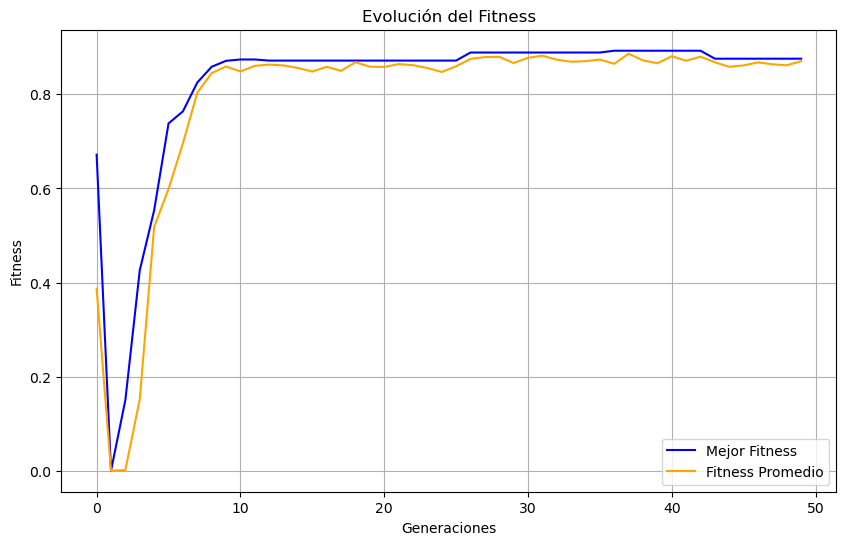

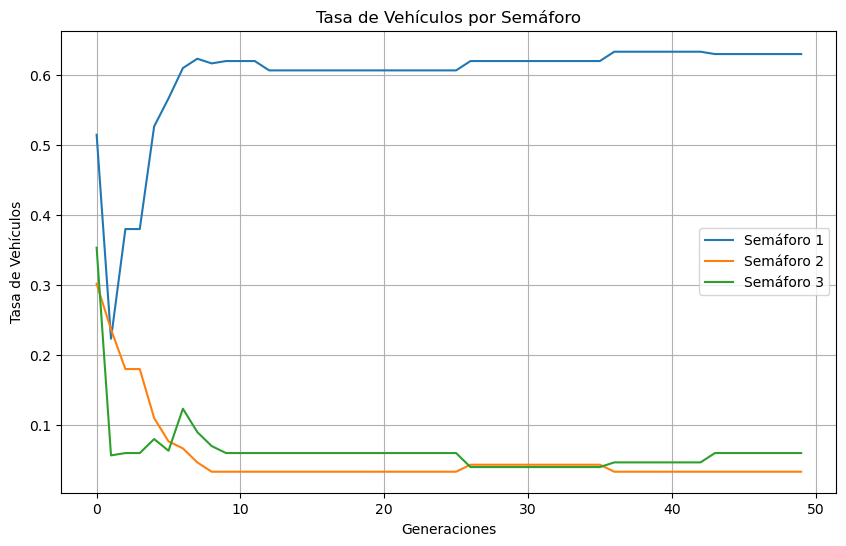

Mejor solución 111111110000000000110111
La tasa del semáforo 0 es de: 0.63
La tasa del semáforo 1 es de: 0.03333333333333333
La tasa del semáforo 2 es de: 0.06


In [3]:
bestChromosome = ampelOptimizationGA() # Pasar True como argumento para ver cada simulación (cada generación)
print(f"Mejor solución {bestChromosome}")
simulateBest(bestChromosome)